# Load libaray

In [1]:
# Standard library imports
import warnings

# Third-party imports for data manipulation and numerical operations
import numpy as np
import pandas as pd
import joblib

# Imports for visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Machine learning and statistical analysis imports
import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from scipy.stats import uniform, linregress

# Imports for mapping
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

# Configuration to suppress specific warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

# Function to display the versions of the imported packages
def show_versions():
    print("numpy version: ", np.__version__)
    print("pandas version: ", pd.__version__)
    print("joblib version: ", joblib.__version__)
    print("matplotlib version: ", matplotlib.__version__)
    print("seaborn version: ", sns.__version__)
    print("scikit-learn version: ", sklearn.__version__)
    print("scipy version: ", linregress.__module__.split('.')[0])
    print("basemap version: ", mpl_toolkits.basemap.__version__)

# Call the function to display versions
show_versions()


numpy version:  1.24.2
pandas version:  2.1.4
joblib version:  1.2.0
matplotlib version:  3.8.4
seaborn version:  0.13.0
scikit-learn version:  1.5.0
scipy version:  scipy
basemap version:  1.4.1


# Train the GMM_brLCP model

In [3]:
# Load the surface sediments data from Tibetan Plateau
data = pd.read_excel('Liang et al., 2024_global and holocene dataset_github.xlsx', sheet_name='Table S1. ss_brGDGTs')
new_df = data[["MBT'5me", 'IR']].dropna()

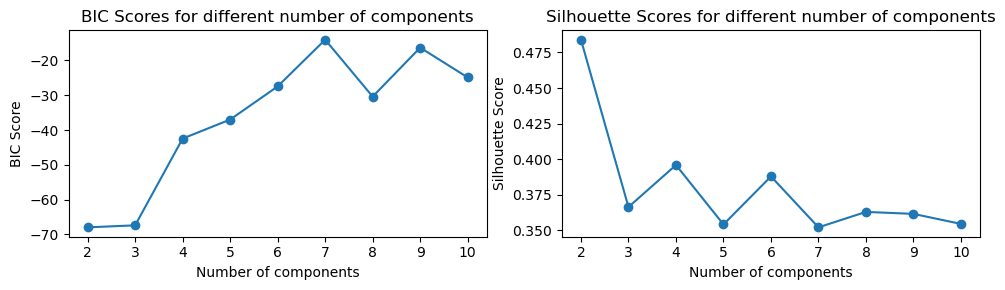

In [5]:
# Initialize variables
bic_scores = []
sil_scores = []

# Evaluate GMM models with different number of components
n_components_range = range(2, 11)

for n_components in n_components_range:
    param_dist = {
        'n_components': [n_components],
        'covariance_type': ['full']
    }

    # Initialize the GaussianMixture model
    gmm = GaussianMixture(random_state=42)

    # Initialize the RandomizedSearchCV object
    random_search = RandomizedSearchCV(gmm, param_distributions=param_dist, n_iter=1, cv=5, random_state=42)

    # Fit the model to the data
    random_search.fit(new_df)

    # Get the best model
    best_gmm = random_search.best_estimator_

    # Fit the best model to the data
    best_gmm.fit(new_df)

    # Compute BIC
    bic_scores.append(best_gmm.bic(new_df))

    # Compute Silhouette Score
    labels = best_gmm.predict(new_df)
    sil_scores.append(silhouette_score(new_df, labels))

# Plot BIC scores
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC Scores for different number of components')
plt.xlabel('Number of components')
plt.ylabel('BIC Score')

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(n_components_range, sil_scores, marker='o')
plt.title('Silhouette Scores for different number of components')
plt.xlabel('Number of components')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



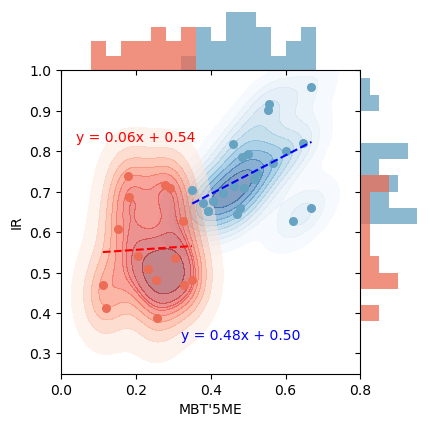

In [7]:
# Import the Gaussian Mixture Model from the mixture module
loaded_gmm = mixture.GaussianMixture(n_components=2, covariance_type="full", random_state=42)

# Fit the model on the new data and predict the labels, incrementing labels by 1 for better readability
labels = loaded_gmm.fit_predict(new_df) + 1

# Copy the original dataframe and add the predicted labels as a new column
data_with_labels = new_df.copy()
data_with_labels['Label'] = labels
data_with_labels['Bias_MAFrf']=data['Bias_MAFrf']
# Display the dataframe with labels
data_with_labels

# Extract the 'MBT'5me' and 'IR' values for both labels for plotting
x1 = data_with_labels[data_with_labels['Label'] == 1]["MBT'5me"]
y1 = data_with_labels[data_with_labels['Label'] == 1]['IR']
x2 = data_with_labels[data_with_labels['Label'] == 2]["MBT'5me"]
y2 = data_with_labels[data_with_labels['Label'] == 2]['IR']

# Initialize a joint grid for the plot with specific dimensions and limits
g = sns.JointGrid(space=0)
g.fig.set_size_inches(4, 4)
g.ax_joint.set_ylim(0.25, 1)
g.ax_joint.set_xlim(0, 0.8)

# Set bin width for histograms
binwidth = 0.04

# Define custom hex colors for the two different groups
hex_color1 = "#EC6C55"
hex_color2 = "#66A2C1"

# Plot data and kernel density plots for each group
sns.kdeplot(x=x1, y=y1, ax=g.ax_joint, cmap="Blues", alpha=0.5, fill=True)
sns.kdeplot(x=x2, y=y2, ax=g.ax_joint, cmap="Reds", alpha=0.5, fill=True)
sns.histplot(x=x1, ax=g.ax_marg_x, color=hex_color2, bins=np.arange(0, 0.8 + binwidth, binwidth), edgecolor='none')
sns.histplot(y=y1, ax=g.ax_marg_y, color=hex_color2, bins=np.arange(0.1, 1 + binwidth, binwidth), edgecolor='none')
sns.histplot(x=x2, ax=g.ax_marg_x, color=hex_color1, bins=np.arange(0, 0.8 + binwidth, binwidth), edgecolor='none')
sns.histplot(y=y2, ax=g.ax_marg_y, color=hex_color1, bins=np.arange(0.1, 1 + binwidth, binwidth), edgecolor='none')

# Scatter plots for visual differentiation
g.ax_joint.scatter(x1, y1, color=hex_color2, s=30)
g.ax_joint.scatter(x2, y2, color=hex_color1, s=30)

# Function to add linear regression lines and equations to the plots
def add_regression_line(x, y, color, ax, pos):
    slope, intercept, _, _, _ = linregress(x, y)
    x_vals = np.linspace(min(x), max(x), 100)  # Limit X values between the minimum and maximum data points
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color=color, linestyle='--')
    equation = f"y = {slope:.2f}x + {intercept:.2f}"
    ax.text(pos[0], pos[1], equation, transform=ax.transAxes, color=color, verticalalignment='top')

add_regression_line(x1, y1, "b", g.ax_joint, pos=(0.4, 0.15))
add_regression_line(x2, y2, "r", g.ax_joint, pos=(0.05, 0.80))

# Disable grid lines for a cleaner look
g.ax_joint.grid(False)
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False)

# Set titles and labels for the axes
g.set_axis_labels("MBT'5ME", "IR")

# Optionally, save the figure to a file
#plt.savefig("D:\D-Holocene T2024\Figure\GMM_figure202400717.pdf", format='pdf')

# Display the plot
plt.show()


# Validate global surface sediment samples by GMM_brLCP model

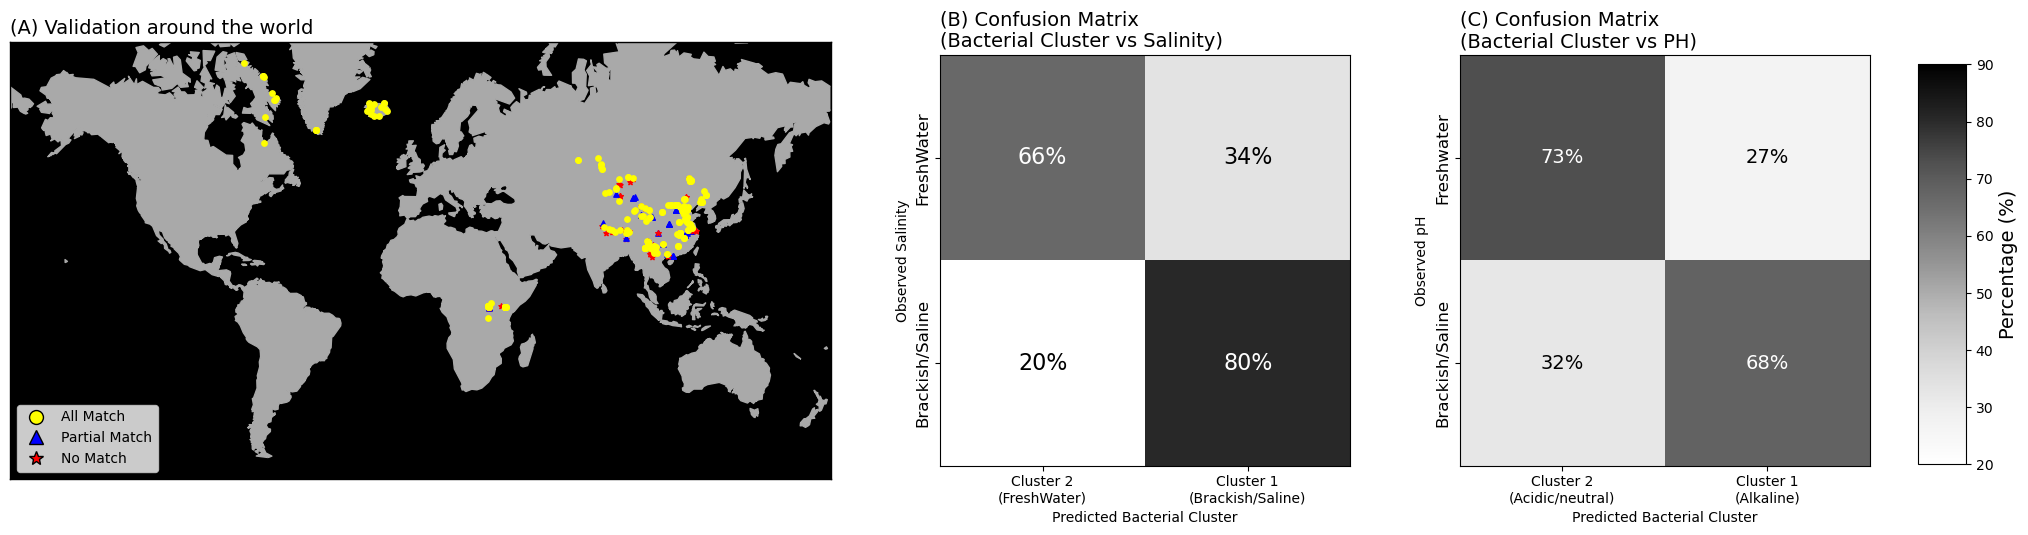

In [9]:


# Load the model from the file
loaded_gmm = joblib.load('brGMM-BAE.pkl')

# Load the global dataset
Global_data = pd.read_excel('Liang et al., 2024_global and holocene dataset_github.xlsx', sheet_name='Global lacustrine SS')

# Check if the column "MBT'5Me" exists in the DataFrame, and if so, rename it
if "MBT'5Me" in Global_data.columns:
    Global_data = Global_data.rename(columns={"MBT'5Me": "MBT'5me"})

# Drop rows with NA values in specific columns
columns_to_check = ["MBT'5me", 'IR', 'Salinity (g/L)', 'PH']
Global_data = Global_data.dropna(subset=columns_to_check)

# Apply the GMM model to predict labels
Global_X = Global_data[["MBT'5me", 'IR']]
predicted_labels = loaded_gmm.predict(Global_X)
Global_data['Predicted_Labels'] = predicted_labels + 1

# Assign Bacterial Cluster and PH predict based on Predicted_Labels
Global_data['Bacterial Cluster'] = np.where(Global_data['Predicted_Labels'] == 2, 'fres', 'salt')
Global_data['PH predict'] = np.where(Global_data['Predicted_Labels'] == 2, 'acid', 'alke')

# Add Salinity and PH-value columns
Global_data['Salinity'] = np.where(Global_data['Salinity (g/L)'] > 0.2, 'salt', 'fres')
Global_data['PH-value'] = np.where(Global_data['PH'] > 8, 'alke', 'acid')

# Define the classification function
def classify_sample(row):
    if row['PH'] >= 8 and row['Salinity (g/L)'] >= 0.2:
        return 'holi-alki'
    elif row['PH'] < 8 and row['Salinity (g/L)'] <= 0.2:
        return 'fresh-acid/neutral'
    elif row['PH'] >= 8 and row['Salinity (g/L)'] <= 0.2:
        return 'fresh-alki'
    elif row['PH'] <= 8 and row['Salinity (g/L)'] > 0.2:
        return 'holi-acid/neutral'
    else:
        return 'unknown'  # If no matching condition

# Apply the classification function and create a new column
Global_data['classification'] = Global_data.apply(classify_sample, axis=1)

# Determine match result
def determine_match(row):
    if (row['Bacterial Cluster'] == 'fres' and row['PH-value'] == 'acid' and row['Salinity'] == 'salt') or \
       (row['Bacterial Cluster'] == 'salt' and row['PH-value'] == 'alke' and row['Salinity'] == 'fres'):
        return 'partial_match'
    elif (row['Bacterial Cluster'] == 'fres' and row['PH-value'] == 'alke' and row['Salinity'] == 'salt') or \
         (row['Bacterial Cluster'] == 'salt' and row['PH-value'] == 'acid' and row['Salinity'] == 'fres'):
        return 'no_match'
    elif (row['Bacterial Cluster'] == 'fres' and row['PH-value'] == 'acid' and row['Salinity'] == 'fres') or \
         (row['Bacterial Cluster'] == 'salt' and row['PH-value'] == 'alke' and row['Salinity'] == 'salt'):
        return 'all_match'
    else:
        return 'partial_match'  # Assign a default match to avoid unknown

Global_data['match_result'] = Global_data.apply(determine_match, axis=1)

# Filter data to include only 'all_match'
all_match_data = Global_data[Global_data['match_result'] == 'all_match']

# Calculate MAF_Bias
Global_data['MAF_Bias'] = Global_data['MAFrf'] - Global_data['MAF']

# Create figure and grid layout
fig = plt.figure(figsize=(24, 8))
gs = GridSpec(1, 3, width_ratios=[2, 1, 1])

# Map plotting
ax0 = fig.add_subplot(gs[0, 0])
m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=75, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c', ax=ax0)
m.drawcoastlines(color='darkgray')
m.fillcontinents(color='darkgray', lake_color='darkgray')
m.drawmapboundary(fill_color='black')

# Calculate projected coordinates for longitude and latitude
Global_data['x'], Global_data['y'] = m(Global_data['longitude'].values, Global_data['latitude'].values)

# Define markers and colors
marker_colors = {
    'all_match': ('o', 'yellow'),
    'partial_match': ('^', 'blue'),
    'no_match': ('*', 'red')
}

# Plot points and set legend
# First plot blue triangles and red stars
for idx, row in Global_data.iterrows():
    # Determine marker shape and color
    if (row['Bacterial Cluster'] == 'fres' and row['PH-value'] == 'acid' and row['Salinity'] == 'salt') or \
       (row['Bacterial Cluster'] == 'salt' and row['PH-value'] == 'alke' and row['Salinity'] == 'fres'):
        marker, color = marker_colors['partial_match']
    elif (row['Bacterial Cluster'] == 'fres' and row['PH-value'] == 'alke' and row['Salinity'] == 'salt') or \
         (row['Bacterial Cluster'] == 'salt' and row['PH-value'] == 'acid' and row['Salinity'] == 'fres'):
        marker, color = marker_colors['no_match']
    else:
        continue
    
    # Plot points
    m.scatter(row['x'], row['y'], marker=marker, color=color, s=15, zorder=5)

# Finally, plot yellow circles
for idx, row in Global_data.iterrows():
    if (row['Bacterial Cluster'] == 'fres' and row['PH-value'] == 'acid' and row['Salinity'] == 'fres') or \
       (row['Bacterial Cluster'] == 'salt' and row['PH-value'] == 'alke' and row['Salinity'] == 'salt'):
        marker, color = marker_colors['all_match']
        
        # Plot points
        m.scatter(row['x'], row['y'], marker=marker, color=color, s=15, zorder=5)

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], marker='o',  color='none',  markerfacecolor='yellow', markersize=10, label='All Match'),
    plt.Line2D([0], [0], marker='^', color='none', markerfacecolor='blue', markersize=10, label='Partial Match'),
    plt.Line2D([0], [0], marker='*', color='none',  markerfacecolor='red', markersize=10, label='No Match')
]
ax0.set_title('(A) Validation around the world', fontsize=14, loc='left')
# Add legend to the map
ax0.legend(handles=legend_elements, loc='lower left')

# Part 1: Bacterial Cluster vs Salinity
y_true1 = Global_data['Salinity']
y_pred1 = Global_data['Bacterial Cluster']
conf_matrix1 = confusion_matrix(y_true1, y_pred1, labels=['fres', 'salt'])
conf_matrix_percentage1 = conf_matrix1.astype('float') / conf_matrix1.sum(axis=1)[:, np.newaxis] * 100

# Confusion matrix 1
ax1 = fig.add_subplot(gs[0, 1])
cmap = plt.get_cmap('Greys')
norm = plt.Normalize(vmin=20, vmax=90)
im1 = ax1.imshow(conf_matrix_percentage1, interpolation='nearest', cmap=cmap, norm=norm)

# Set axis labels
ax1.set(xticks=np.arange(conf_matrix1.shape[1]),
        yticks=np.arange(conf_matrix1.shape[0]),
        xticklabels=['Cluster 2\n(FreshWater)', 'Cluster 1\n(Brackish/Saline)'], 
        yticklabels=['FreshWater', 'Brackish/Saline'],
        ylabel='Observed Salinity',
        xlabel='Predicted Bacterial Cluster')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=90, va='center', fontsize=12)
ax1.set_title('(B) Confusion Matrix\n(Bacterial Cluster vs Salinity)', fontsize=14, loc='left')

# Display percentage in each cell
thresh1 = conf_matrix_percentage1.max() / 2.
for i in range(conf_matrix1.shape[0]):
    for j in range(conf_matrix1.shape[1]):
        if conf_matrix1[i, j] != 0:  # Only display non-zero values
            ax1.text(j, i, f'{conf_matrix_percentage1[i, j]:.0f}%',
                     ha='center', va='center', fontsize=16,
                     color='white' if conf_matrix_percentage1[i, j] > thresh1 else 'black')

# Part 2: Bacterial Cluster vs pH
Global_data = Global_data.dropna(subset=['PH'])
Global_data['PH-value'] = np.where(Global_data['PH'] >= 7, 'alke', 'acid')
y_true2 = Global_data['PH-value']
y_pred2 = Global_data['PH predict']
conf_matrix2 = confusion_matrix(y_true2, y_pred2, labels=['acid', 'alke'])
conf_matrix_percentage2 = conf_matrix2.astype('float') / conf_matrix2.sum(axis=1)[:, np.newaxis] * 100

# Confusion matrix 2
ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.imshow(conf_matrix_percentage2, interpolation='nearest', cmap=cmap, norm=norm)

# Set axis labels
ax2.set(xticks=np.arange(conf_matrix2.shape[1]),
        yticks=np.arange(conf_matrix2.shape[0]),
        xticklabels=['Cluster 2\n(Acidic/neutral)', 'Cluster 1\n(Alkaline)'], 
        yticklabels=['Freshwater', 'Brackish/Saline'],
        ylabel='Observed pH',
        xlabel='Predicted Bacterial Cluster')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=90, va='center', fontsize=12)
ax2.set_title('(C) Confusion Matrix\n(Bacterial Cluster vs PH)', fontsize=14, loc='left')

# Display percentage in each cell
thresh2 = conf_matrix_percentage2.max() / 2.
for i in range(conf_matrix2.shape[0]):
    for j in range(conf_matrix2.shape[1]):
        if conf_matrix2[i, j] != 0:  # Only display non-zero values
            ax2.text(j, i, f'{conf_matrix_percentage2[i, j]:.0f}%',
                     ha='center', va='center', fontsize=14,
                     color='white' if conf_matrix_percentage2[i, j] > thresh2 else 'black')

# Add shared color bar
cbar_ax = fig.add_axes([0.92, 0.24, 0.02, 0.50])  # Modify the position and size of the color bar
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Percentage (%)', fontsize=14)
cbar.set_ticks(np.arange(20, 91, 10))
cbar.set_ticklabels([f'{int(tick)}' for tick in np.arange(20, 91, 10)])

#plt.savefig("D:\\D-Holocene T2024\\Figure\\Global validation\\validation map.pdf", format='pdf')

plt.show()


C:\Users\jie liang\AppData\Local\Temp\ipykernel_22532\364600019.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(ax=axs[0], x='classification', y='MAF_Bias', data=Global_data, palette="muted")
C:\Users\jie liang\AppData\Local\Temp\ipykernel_22532\364600019.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels_1)
C:\Users\jie liang\AppData\Local\Temp\ipykernel_22532\364600019.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(ax=axs[1], x='Bacterial Cluster', y='MAF_Bias', data=all_match_data, palette="muted")
C:\Users\jie liang\AppData\Local\Temp\ipykernel_2

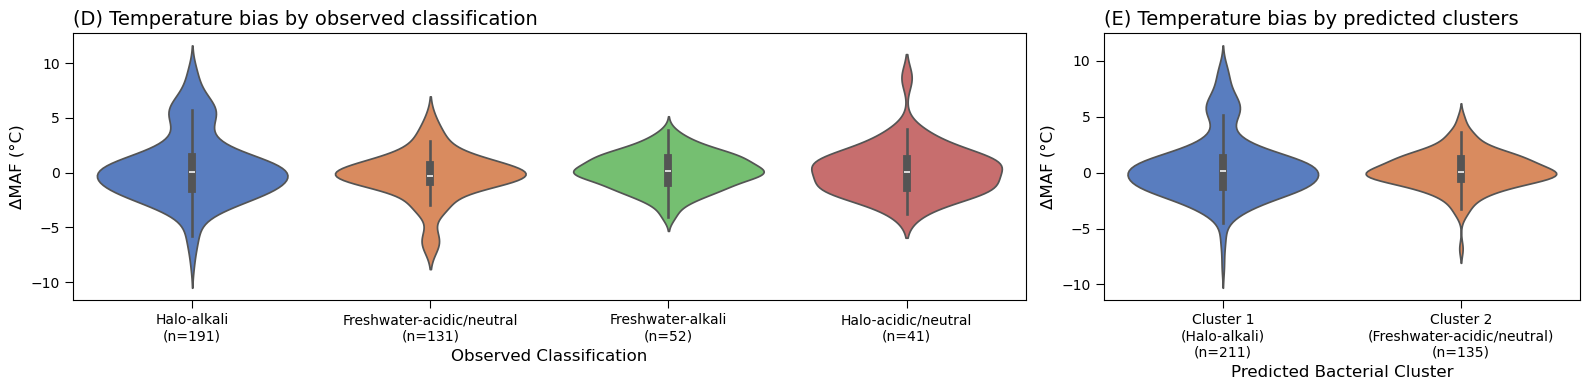

In [11]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [2, 1]})

# First violin plot

ax = sns.violinplot(ax=axs[0], x='classification', y='MAF_Bias', data=Global_data, palette="muted")

# Custom X labels for the first plot
new_labels_1 = [
    'Halo-alkali\n(n={})'.format(Global_data[Global_data['classification'] == 'holi-alki'].shape[0]),
    'Freshwater-acidic/neutral\n(n={})'.format(Global_data[Global_data['classification'] == 'fresh-acid/neutral'].shape[0]),
    'Freshwater-alkali\n(n={})'.format(Global_data[Global_data['classification'] == 'fresh-alki'].shape[0]),
    'Halo-acidic/neutral\n(n={})'.format(Global_data[Global_data['classification'] == 'holi-acid/neutral'].shape[0])
]

# Set the new labels
ax.set_xticklabels(new_labels_1)

# Customize the plot appearance for publication
axs[0].set_title('(D) Temperature bias by observed classification', fontsize=14, loc='left')
axs[0].set_xlabel('Observed Classification', fontsize=12)
axs[0].set_ylabel('ΔMAF (°C)', fontsize=12)
axs[0].tick_params(axis='x', labelsize=10, direction='out', length=6)
axs[0].tick_params(axis='y', labelsize=10, direction='out', length=6)



all_match_data = Global_data[Global_data['match_result'].isin(['partial_match', 'all_match'])]

ax = sns.violinplot(ax=axs[1], x='Bacterial Cluster', y='MAF_Bias', data=all_match_data, palette="muted")

# Custom X labels for the second plot
new_labels_2 = [
    'Cluster 1\n(Halo-alkali)\n(n={})'.format(all_match_data[all_match_data['Bacterial Cluster'] == 'salt'].shape[0]),
    'Cluster 2\n(Freshwater-acidic/neutral)\n(n={})'.format(all_match_data[all_match_data['Bacterial Cluster'] == 'fres'].shape[0])
]

# Set the new labels
ax.set_xticklabels(new_labels_2)

# Customize the plot appearance for publication
axs[1].set_title('(E) Temperature bias by predicted clusters', fontsize=14, loc='left')
axs[1].set_xlabel('Predicted Bacterial Cluster', fontsize=12)
axs[1].set_ylabel('ΔMAF (°C)', fontsize=12)
axs[1].tick_params(axis='x', labelsize=10, direction='out', length=6)
axs[1].tick_params(axis='y', labelsize=10, direction='out', length=6)

plt.tight_layout()

#plt.savefig("D:\\D-Holocene T2024\\Figure\\Global validation\\violinplot bias.pdf", format='pdf')

plt.show()

In [13]:
all_match_data = Global_data[Global_data['match_result'].isin(['partial_match', 'all_match'])]
classifications = all_match_data ['Bacterial Cluster'].unique()
classifications

summary_list = []

for classification in classifications:
    class_data = all_match_data [Global_data['Bacterial Cluster'] == classification]['MAF_Bias']
    summary = class_data.describe()
    summary_list.append({
        'Classification': classification,
        'Count': summary['count'],
        'Mean': summary['mean'],
        'Std': summary['std'],
        'Min': summary['min'],
        '25%': summary['25%'],
        '50%': summary['50%'],
        '75%': summary['75%'],
        'Max': summary['max']
    })

summary_table = pd.DataFrame(summary_list)

summary_table.set_index('Classification', inplace=True)

styled_table = summary_table.style.format({
    'Count': '{:,.0f}',
    'Mean': '{:.2f}',
    'Std': '{:.2f}',
    'Min': '{:.2f}',
    '25%': '{:.2f}',
    '50%': '{:.2f}',
    '75%': '{:.2f}',
    'Max': '{:.2f}'
}).set_caption('Summary Statistics of MAF_Bias by Observerd Classification')


styled_table



C:\Users\jie liang\AppData\Local\Temp\ipykernel_22532\2823479741.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_data = all_match_data [Global_data['Bacterial Cluster'] == classification]['MAF_Bias']
C:\Users\jie liang\AppData\Local\Temp\ipykernel_22532\2823479741.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_data = all_match_data [Global_data['Bacterial Cluster'] == classification]['MAF_Bias']


,Count,Mean,Std,Min,25%,50%,75%,Max
Classification,,,,,,,,
salt,211,0.48,2.85,-8.35,-1.26,0.13,1.33,9.44
fres,135,0.20,1.68,-6.81,-0.60,0.07,1.27,4.95


In [15]:

classifications = Global_data['classification'].unique()

summary_list = []

for classification in classifications:
    class_data = Global_data[Global_data['classification'] == classification]['MAF_Bias']
    summary = class_data.describe()
    summary_list.append({
        'Classification': classification,
        'Count': summary['count'],
        'Mean': summary['mean'],
        'Std': summary['std'],
        'Min': summary['min'],
        '25%': summary['25%'],
        '50%': summary['50%'],
        '75%': summary['75%'],
        'Max': summary['max']
    })


summary_table = pd.DataFrame(summary_list)


summary_table.set_index('Classification', inplace=True)

styled_table = summary_table.style.format({
    'Count': '{:,.0f}',
    'Mean': '{:.2f}',
    'Std': '{:.2f}',
    'Min': '{:.2f}',
    '25%': '{:.2f}',
    '50%': '{:.2f}',
    '75%': '{:.2f}',
    'Max': '{:.2f}'
}).set_caption('Summary Statistics of MAF_Bias by Observerd Classification')

styled_table


,Count,Mean,Std,Min,25%,50%,75%,Max
Classification,,,,,,,,
holi-alki,191,0.43,3.11,-8.35,-1.46,0.06,1.45,9.44
fresh-alki,52,-0.31,2.22,-6.81,-0.83,-0.29,0.66,4.95
fresh-acid/neutral,131,0.14,1.63,-4.10,-0.99,0.18,1.34,3.91
holi-acid/neutral,41,0.18,2.27,-3.79,-1.38,0.03,1.27,8.66


# Predict Holocene records using GMM_brLCP model

In [17]:
# Load the model from the file
loaded_gmm = joblib.load('brGMM-BAE.pkl')

In [19]:
def plot_scatter(data, age_col, label_col, predicted_labels_col, title=None):

    data.loc[data[predicted_labels_col] == 2, label_col] = 'Freshwater Species'
    data.loc[data[predicted_labels_col] == 1, label_col] = 'Halo-alkalophylic Species'

    plt.figure(figsize=(5, 3))
 
    colors = {'Freshwater Species': 'red', 'Halo-alkalophylic Species': 'blue'}

    for label, color in colors.items():
        subset = data[data[label_col] == label]
        plt.scatter(subset[age_col], [1] * len(subset), c=color, label=label, alpha=0.5, edgecolor='k')

    plt.legend()
    plt.title(title if title else "")
    plt.xlabel('Age (BP)')
    plt.yticks([1], ['Bacterial Cluster'])  
    plt.ylabel('')
    plt.grid(False)
    plt.show()


QH: ['Halo-alkalophylic Species']


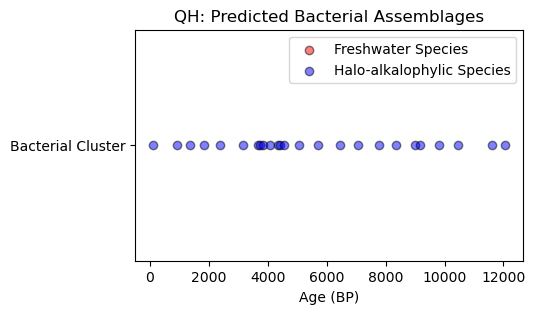

BGC: ['Freshwater Species' 'Halo-alkalophylic Species']


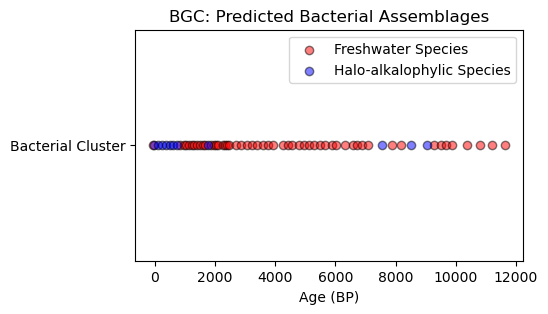

NG: ['Halo-alkalophylic Species' 'Freshwater Species']


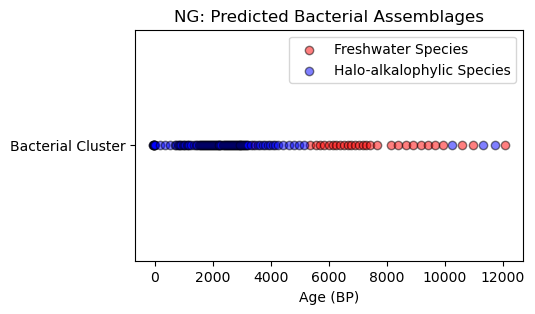

GH: ['Freshwater Species']


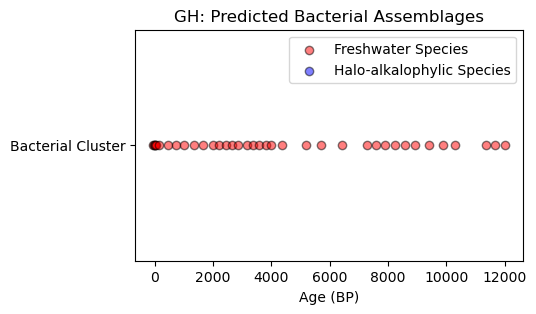

CQ: ['Freshwater Species']


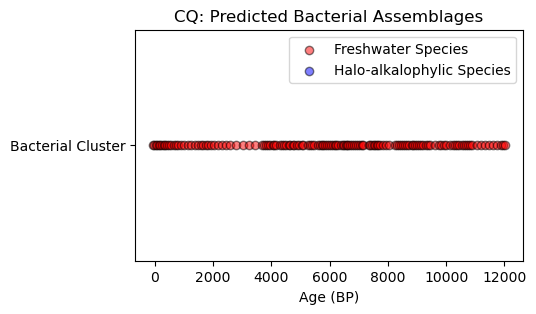

TCQH: ['Freshwater Species']


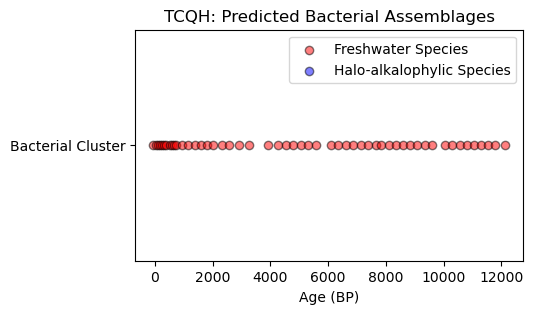

LG: ['Freshwater Species']


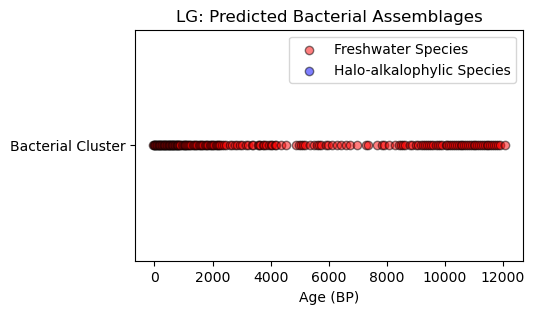

TC: ['Freshwater Species']


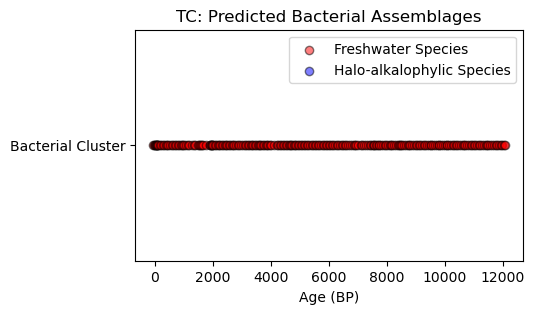

In [21]:
# List of Lake name
sheet_names = ["QH","BGC","NG","GH", "CQ", "TCQH","LG", "TC"]# 

# Loop through each sheet name
for sheet_name in sheet_names:
   
    data = pd.read_excel('Liang et al., 2024_global and holocene dataset_github.xlsx', sheet_name=sheet_name)
    data.columns = data.iloc[0]
    data = data[1:].reset_index(drop=True)
  
    # Clean and preprocess the data
    if "MBT'5Me" in data.columns:
        data = data.rename(columns={"MBT'5Me": "MBT'5me"})
    data = data.dropna(subset=["MBT'5me", 'IR'])

    # Prepare the features for prediction
    X = data[["MBT'5me", 'IR']]

    # Predict the labels using the GMM model
    predicted_labels = loaded_gmm.predict(X)
    data['Predicted_Labels'] = predicted_labels + 1

    # Map the predicted labels to bacterial clusters
    data['Bacterial Cluster'] = ''
    data.loc[data['Predicted_Labels'] == 2, 'Bacterial Cluster'] = 'Freshwater Species'
    data.loc[data['Predicted_Labels'] == 1, 'Bacterial Cluster'] = 'Halo-alkalophylic Species'

    # Print unique bacterial clusters for verification
    print(f"{sheet_name}: {data['Bacterial Cluster'].unique()}")

    # Plot the scatter plot with the site name as the title
    plot_scatter(data, 'Age (BP)', 'Bacterial Cluster', 'Predicted_Labels', title=f"{sheet_name}: Predicted Bacterial Assemblages")


## Holocene plots

In [23]:


# List of sheet names
sheet_names = ["QH", "BGC", "NG", "GH", "CQ", "TCQH", "LG", "TC"]


df_list = []

# Loop through each sheet name
for sheet_name in sheet_names:
    # Read the data from the specific sheet
    data = pd.read_excel('Liang et al., 2024_global and holocene dataset_github.xlsx', sheet_name=sheet_name)
    
    # Set the second row as the header
    data.columns = data.iloc[0]
    data = data[1:]
    
    # Extract relevant columns
    columns_to_keep = [
        'Age (BP)', 
        'MAFrecons', 
        'T_min', 
        'T_max', 
        "MBT'5Me", 
        'IR', 
        'Predicted bacterial assemblages'
    ]
    subset = data[columns_to_keep].copy()
    
    # Add a new column for the lake (sheet) name
    subset['lake'] = sheet_name
    
    # Append the subset dataframe to the list
    df_list.append(subset)

# Concatenate all the dataframes in the list into one long dataframe
combined_df = pd.concat(df_list, ignore_index=True)




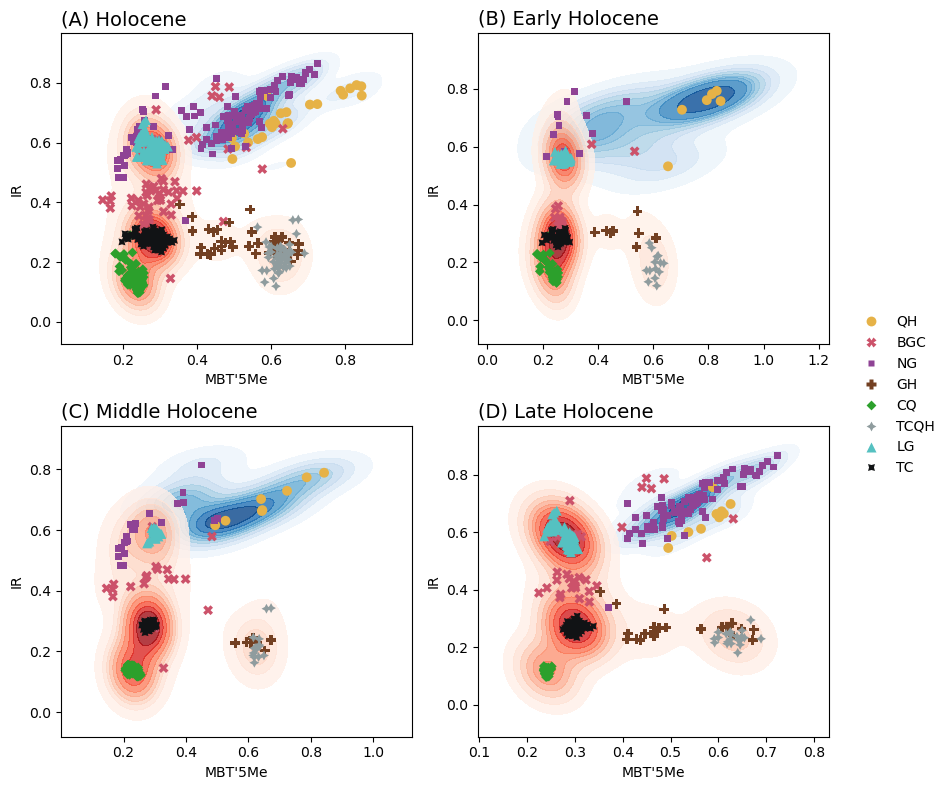

In [25]:


def classify_holocene(age):
    if age <= 12000 and age > 8200:
        return 'early Holocene'
    elif age <= 8200 and age > 4200:
        return 'middle Holocene'
    elif age <= 4200:
        return 'late Holocene'

combined_df['Holoceneperiod'] = combined_df['Age (BP)'].apply(classify_holocene)


early_holocene_df = combined_df[combined_df['Holoceneperiod'] == 'early Holocene']
middle_holocene_df = combined_df[combined_df['Holoceneperiod'] == 'middle Holocene']
late_holocene_df = combined_df[combined_df['Holoceneperiod'] == 'late Holocene']


lake_colors = {
    'BGC': '#cc526a',
    'NG': '#8f4395',
    'CQ': '#2ca02c',
    'QH': '#e6b247',
    'GH': '#734022',
    'TCQH': '#8f9c9e',
    'LG': '#55c1c1',
    'TC': '#111315',
}


cluster_colors = {
    'Cluster 1': '#66A2C1', 
    'Cluster 2': '#EC6C55'  
}


def plot_joint_with_kde(ax, data, title):   
    for name, group in data.groupby('Predicted bacterial assemblages'):
        x = group["MBT'5Me"]
        y = group['IR']
        cmap = 'Blues' if name == 'Cluster 1' else 'Reds'
        sns.kdeplot(x=x, y=y, ax=ax, cmap=cmap, alpha=0.8, fill=True)  
    scatter = sns.scatterplot(data=data, x="MBT'5Me", y='IR', hue='lake', style='lake', palette=lake_colors, ax=ax, s=50,edgecolors='none')#,linewidth=0.01
    
    ax.set_xlabel("MBT'5Me")
    ax.set_ylabel('IR')
    ax.set_title(title, fontsize=14, loc='left') 
    ax.get_legend().remove()  


fig, axs = plt.subplots(2, 2, figsize=(10,8))


plot_joint_with_kde(axs[0, 0], combined_df, '(A) Holocene')


plot_joint_with_kde(axs[0, 1], early_holocene_df, '(B) Early Holocene')


plot_joint_with_kde(axs[1, 0], middle_holocene_df, '(C) Middle Holocene')


plot_joint_with_kde(axs[1, 1], late_holocene_df, '(D) Late Holocene')


plt.tight_layout(rect=[0, 0, 0.85, 1]) 

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,  loc='center left', bbox_to_anchor=(0.85, 0.5), ncol=1, frameon=False)
#plt.savefig("D:\\D-Holocene T2024\\Figure\\Global validation\\GMM Holocene.pdf", format='pdf')
plt.show()
